In [2]:
import tensorflow as tf
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping,ModelCheckpoint, TensorBoard, ReduceLROnPlateau
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
df = pd.read_excel('/Users/qkrtm/Desktop/KAU/4-1/Jongsul/gitJongsul/RNN/dataset/70man.xlsx','70man')
#df = ex1.parse('sheet1')
df.to_csv('csvfile.csv',encoding='utf-8')
#df = pd.read_csv(csv_path)
#나중에 리브레뷰의 혈당데이터를 읽어 예측해보려한다,

In [4]:
df.tail()
df.head(1)
#교수님의 혈당데이터는 총 2129개
#이제 이 데이터를 통해 저번에 했던 3일치 정도의 혈당을 예측해보자
# 3일  = 하루 세끼 3개 * 3 은 총 9개예측하기

,Time,Glucose(mg/dL),Sex
0,2020-07-08 15:30:00,173,1


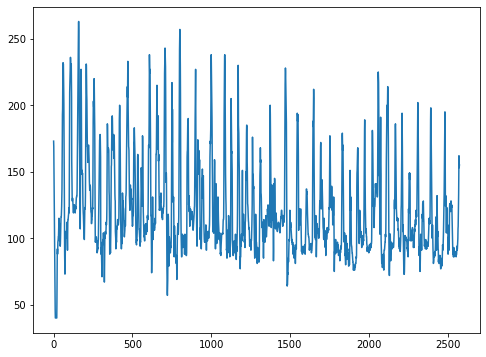

In [5]:
#history_size는 과거 정보 창의 크기
# target_size는 미래 예측 레이블값
df['Glucose(mg/dL)'].plot()

In [6]:
target = ['Glucose(mg/dL)']

In [7]:
shift_days = 1
shift_steps= shift_days * 24

In [8]:
#교차 예측하는데이터
df_targets = df[target].shift(-shift_steps)

In [9]:
df[target].head(shift_steps+5)
#미래 예측을 위해 교차 이동 

,Glucose(mg/dL)
0,173
1,169
2,155
3,136
4,120
5,111
6,97
7,76
8,66
9,58


In [10]:
#기존 데이터
df_targets.tail(5)

,Glucose(mg/dL)
2571,NaN
2572,NaN
2573,NaN
2574,NaN
2575,NaN


In [11]:
#우리는 pandas 데이터 프레임을 신경망에 입력할 수 있도록
#넘파이 배열로 변환
#교차 예측으로 뒤에 NaN이 들어왔으므로 마지막 부분 제거 후 유효데이터만 유지
#입력 및 출력 데이터에 동일한 배열 모양 필요

In [12]:
x1 = df['Sex'].values[0:-shift_steps]
x2 = df['Glucose(mg/dL)'].values[0:-shift_steps]
x_data = np.c_[x2,x1]

In [13]:
print(type(x_data))
print("shape: ",x_data.shape)
#2552* 2의 배열이다.

<class 'numpy.ndarray'>
shape:  (2552, 2)


In [14]:
#출력에서의 배열값
y_data = df_targets.values[:-shift_steps]
print(type(y_data))
print("shape :", y_data.shape)
#출력 결과는 미래 혈당만이므로 2552*1이다.

<class 'numpy.ndarray'>
shape : (2552, 1)


In [15]:
#데이터 세트의 관측 수 (샘플)
num_data = len(x_data)
num_data

2552

In [16]:
#학습용 데이터 셋으로 사용할 데이터셋의 비율
train_split = 0.9

In [17]:
#학습데이터수
num_train = int(train_split*num_data)
num_train

2296

In [18]:
#test 관측수
num_test = num_data - num_train
num_test

256

In [19]:
#학습 및 테스트 입력
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train)+len(x_test)
#전체 데이터 갯수가 나와야정답

2552

In [20]:
#학슴 및 테스트 출력
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train)+len(y_test)

2552

In [21]:
#입력 신호의 수
num_x_signals = x_data.shape[1]
print(x_data[1])
num_x_signals
#2개 시간과 혈당값

[169   1]


2

In [22]:
#출력 신호의 수
num_y_signals = y_data.shape[1]
num_y_signals
#출력값 혈당 값 1개

1

In [23]:
#데이터 구간 조정하기
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))
#최고 혈당, 최저 혈당

Min: 1
Max: 263


In [24]:
#신경 망은 대략 -1에서 1사이 값에서 가장 잘 작동하므로
#데이터가 신경망에 입력되기 전에 데이터 값 범위를 조장
#이는 SCIKIT-Learn으로 사용
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)


In [25]:
x_test_scaled = x_scaler.transform(x_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [26]:
#데이터 생성기
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(2296, 2)
(2296, 1)


In [27]:
#학습 데이터에서 무작위 선택한 짧은 시퀀스 배치 생성
def batch_generator(batch_size, sequence_length):
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        yield (x_batch, y_batch)

In [28]:
batch_size= 256

In [29]:
#24시간 * 7은 일주일 * 4는 4주 즉 총 값은 한달
sequence_length = 24 * 7 * 4
sequence_length

672

In [30]:
generator = batch_generator(batch_size=batch_size,sequence_length=sequence_length)

In [31]:
x_batch,y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(256, 672, 2)
(256, 672, 1)


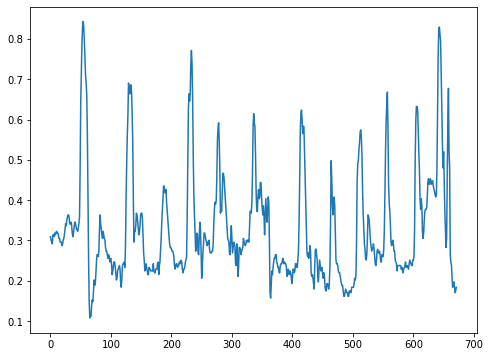

In [32]:
#20개 혈당 데이터로 그래프 그리기
batch = 0 # First sequence in the batch.
signal = 0 # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

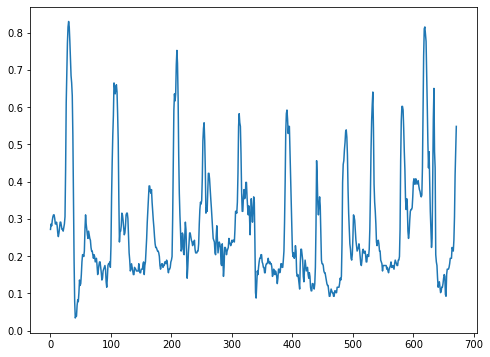

In [33]:
#출력신호 20개, 이는 주어진 20개 입력신호를 학습하여 예측해야 하는
#정답 값이다.
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [34]:
#validation set 만들기
validation_data = (np.expand_dims(x_test_scaled, axis=0),
 np.expand_dims(y_test_scaled, axis=0))

In [35]:
#RNN 만들기
model = Sequential()
#Keras api 사용


In [36]:
# Gate Recurrent Unit(GRU)를 네트워크에 추가
model.add(GRU(units=512,
 return_sequences=True,
 input_shape=(None, num_x_signals,)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [37]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [38]:
#50번의 예열 기간으로써 이 50번까지는 신뢰하지 않음.
warmup_steps = 50

In [39]:
def loss_mse_warmup(y_true, y_pred):
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [40]:
optimizer = RMSprop(lr=1e-3)

In [41]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         791040    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 791,553
Trainable params: 791,553
Non-trainable params: 0
_________________________________________________________________


In [43]:
#Callback 함수
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
 monitor='val_loss',
verbose=1,
save_weights_only=True,
save_best_only=True)

In [44]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
 patience=5, verbose=1)

In [45]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
 histogram_freq=0,
write_graph=False)
#이 콜백은 마지막 에포크 이후에 검증 손실이 개선되지 않으면 (patience = 0으로 표시됨) 옵티마이저의 학습률을 감소시
#킵니다. 학습률은 facgtor의 값을 곱하여 감소될 것입니다. 우리는 1e-3의 시작 학습률을 설정했으므로 0.1을 곱하면 1e-4
#의 학습률이 됩니다

In [46]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
 factor=0.1,
min_lr=1e-4,
patience=0,
verbose=1)

In [47]:
callbacks = [callback_early_stopping,
 callback_checkpoint,
 callback_tensorboard,
 callback_reduce_lr]

In [48]:
#RNN 학습
model.fit_generator(generator=generator,
 epochs=10,
 steps_per_epoch=5,
 validation_data=validation_data,
 callbacks=callbacks)

Epoch 1/10
4/5 [=======================>......] - ETA: 50s - loss: 0.0507 
Epoch 00001: val_loss improved from inf to 0.03707, saving model to 23_checkpoint.keras
5/5 [==============================] - 264s 53s/step - loss: 0.0477 - val_loss: 0.0371
Epoch 2/10
4/5 [=======================>......] - ETA: 53s - loss: 0.0295 
Epoch 00002: val_loss improved from 0.03707 to 0.02003, saving model to 23_checkpoint.keras
5/5 [==============================] - 283s 57s/step - loss: 0.0291 - val_loss: 0.0200
Epoch 3/10
4/5 [=======================>......] - ETA: 1:26 - loss: 0.0280
Epoch 00003: val_loss did not improve from 0.02003

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5/5 [==============================] - 434s 87s/step - loss: 0.0282 - val_loss: 0.0260
Epoch 4/10
4/5 [=======================>......] - ETA: 1:12 - loss: 0.0286
Epoch 00004: val_loss did not improve from 0.02003

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001.
5/5 [====

In [49]:
try:
 model.load_weights(path_checkpoint)
except Exception as error:
 print("Error trying to load checkpoint.")
 print(error)

In [50]:
#테스트셋 에 대한 성능 파악
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
 y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 403ms/sample - loss: 0.0200


In [51]:
print("loss (test-set):", result)

loss (test-set): 0.020029217004776


In [52]:
#예측값 y^ 만들어 내기
def plot_comparison(start_idx, length=100, train=True):
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    end_idx = start_idx + length
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    for signal in range(len(target)):
        signal_pred = y_pred_rescaled[:, signal]
        signal_true = y_true[:, signal]
        plt.figure(figsize=(15,5))
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15
)
        # Plot labels etc.
        plt.ylabel(target[signal])
        plt.legend()
        plt.show()

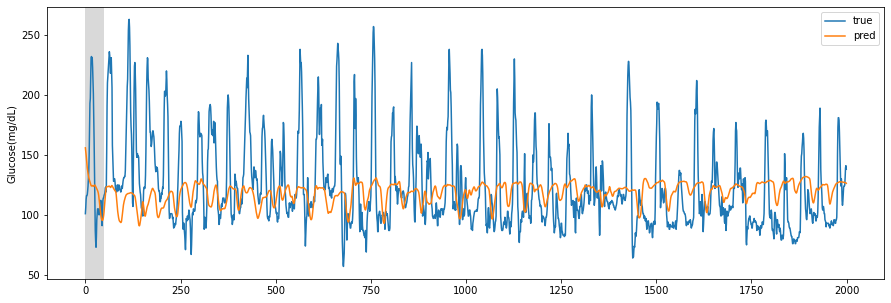

In [57]:
#예측 그래프 생성
plot_comparison(start_idx=20, length=2000, train=True)

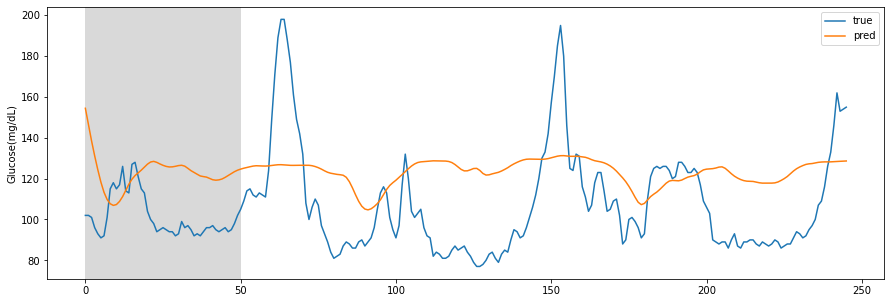

In [62]:
plot_comparison(start_idx=10, length=2000, train=False)

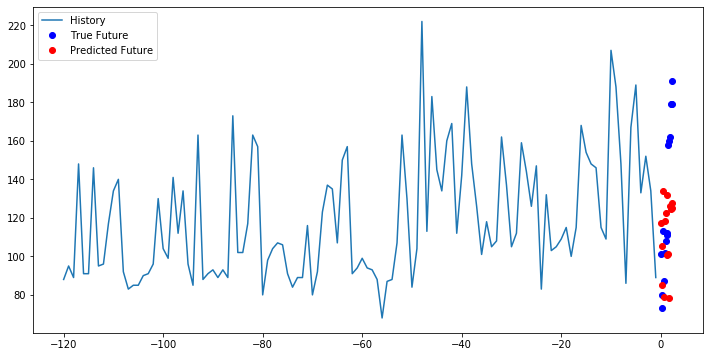

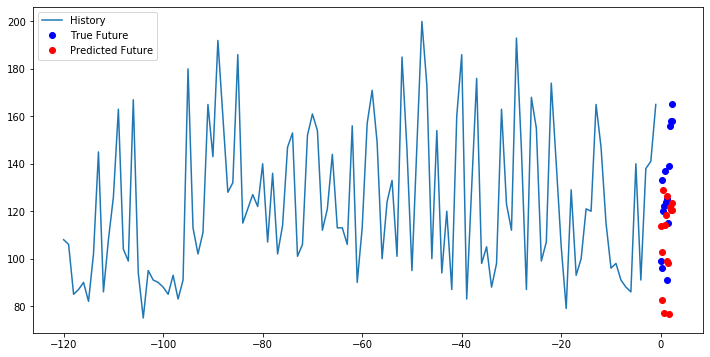

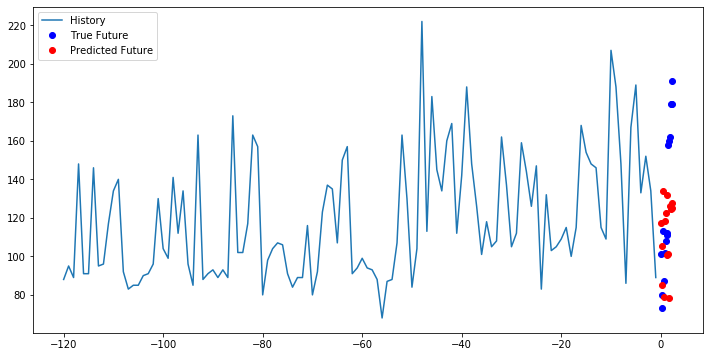

In [203]:
#학습된 네트워크가 미래예측을 잘 배웠는지 확인
#빨간 점이 예측값, 파란점이 실제 Y라벨
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])